In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier

import networkx as nx
import networkx.algorithms.community as nxcom
import community
from collections import Counter
import pickle

In [3]:
num_datasets_per_comparison = {
'ATB_v_LTBI': 16,
'ATB_v_HC' : 15,
'ATB_v_OD': 10,
'LTBI_v_HC': 9}

#### set the *q-value* threshold & comparison

In [4]:
qval_thresh = 0.05

In [5]:
comparison_X = 'LTBI_v_HC'

#### set parameters for plotting

In [6]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

#### specify directory where differential gene data is stored

In [7]:
#use this path for personal computer
#diff_exp_data_dir = "/Users/rogervargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#use this path for Gates MRI computer
#diff_exp_data_dir = "/Users/RogerVargas/OneDrive - Bill & Melinda Gates Medical Research Institute/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#use this path for O2 computing cluster
diff_exp_data_dir = "/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/Pooled Differential Gene Expression/"

#### specify directory for pickling objects

In [8]:
#use this path for O2 computing cluster
pickled_objects_dir = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/Pickled Files/'

### *Function* for visualizing distribution of edge weights from pooled (significant) logFC changes across datasets

In [9]:
def plot_distribution_of_edge_weights(ax, edge_weight_distr_counter_dict, plot_title, linecolor):
    
    #convert Counter dict to series
    edge_weight_distr_series = pd.Series(edge_weight_distr_counter_dict).sort_index()
    
    #get the keys & values from Counter dict (with Edge Weight distr)
    edge_weight_values = edge_weight_distr_series.index
    edge_weight_count = edge_weight_distr_series.values
    edge_weight_count_norm = np.array(edge_weight_count) / float(np.sum(edge_weight_count)) #normalize counts
    
    ax.bar(edge_weight_values , edge_weight_count_norm, color = 'white' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.bar(edge_weight_values[edge_weight_distr_series.index <= -3] , edge_weight_count_norm[edge_weight_distr_series.index <= -3], color = 'blue' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.bar(edge_weight_values[edge_weight_distr_series.index >= 3] , edge_weight_count_norm[edge_weight_distr_series.index >= 3], color = 'blue' , width = 1.0 , edgecolor='black', linewidth=0.5)
    ax.plot(edge_weight_values , edge_weight_count_norm, color = linecolor , linewidth = 2.5)
    
    # calculate the number of the edges that had weight <= -3
    negative_edge_weights_for_network = edge_weight_count[edge_weight_distr_series.index <= -3].sum()
    
    # calculate the number of the edges that had weight >= 3
    positive_edge_weights_for_network = edge_weight_count[edge_weight_distr_series.index >= 3].sum()

    ax.set_title(plot_title, fontsize = 12, color = 'k')
    ax.set_ylabel('Proportion of Edges', fontsize = 12, color = 'k')
    ax.set_xlabel(f'Edge Weights \n (Num Edges <= -3: {negative_edge_weights_for_network}) \n (Num Edges >= 3: {positive_edge_weights_for_network})' , fontsize = 12, color = 'k')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.set_yscale('log')

    ax.tick_params(labelcolor = 'k')
    ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')
    
    for axis in [ax.yaxis]:
        axis.set_major_formatter(FormatStrFormatter('%.5f'))
        
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

## Compute Edges (and corresponding weights) from pooled logFC matrix

In [11]:
logFC_table_filename = f'{comparison_X}_signif_logFC_qval_thresh_{qval_thresh}.csv'

# read in CSV file with significant logFC changes for genes between comparison X samples collected from various datasets
diff_gene_exp_df = pd.read_csv(diff_exp_data_dir + logFC_table_filename).set_index('Unnamed: 0')
diff_gene_exp_df.rename_axis('gene' , inplace = True)

# Construct simplified matrix of logFC direction from DataFrame with significant logFC changes across all analyses by converting values:
# +1 if logFC > 0
#  0 if logFC = 0
# -1 if logFC < 0

# store copy of array from dataframe with sig. logFC values (rows = genes, columns = GSE ID)
direc_diff_gene_exp_matrix = diff_gene_exp_df.copy().values 

# replace values in logFC matrix
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix > 0.0] = 1
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix == 0.0] = 0
direc_diff_gene_exp_matrix[direc_diff_gene_exp_matrix < 0.0] = -1

# convert to lower memory int8 datatype
direc_diff_gene_exp_matrix = direc_diff_gene_exp_matrix.astype('int8')

# compute the dot product between every two pairs of gene vectors (will calculate the edges weights for our network)
# Compute $M \cdot M^T \text{ to get } i \cdot j \text{ , } \forall \text{ pairs of rows } i, j \text{ in matrix } M$
# multiply direction logFC matrix by its transpose to get the dot products between all pairs of rows
network_edge_weight_matrix = direc_diff_gene_exp_matrix.dot(direc_diff_gene_exp_matrix.T)

# the row/column annotation (genes) can be copied from the logFC differential gene expression DataFrame
network_edge_weight_matrix_labels = pd.Series(list(diff_gene_exp_df.index) , index = range(0 , len(diff_gene_exp_df.index)))

# DISTRIBUTION OF EDGE WEIGHTS

#number of rows / columns
num_genes = np.shape(network_edge_weight_matrix)[0]

# retrieve the distribution of the Edge Weights by returning the upper triangular part of the matrix
edge_weight_array = network_edge_weight_matrix[np.triu_indices(num_genes, k = 0)]

#convert array to a Counter dict to save space (keys: edge weight values, values: count of edge weights in edge weight distribution)
edge_weight_distr_counter_dict = Counter(list(edge_weight_array))

In [12]:
network_edge_weight_matrix

array([[ 1,  0, -1, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [-1,  0,  1, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int8)

In [13]:
np.shape(network_edge_weight_matrix)

(29968, 29968)

In [14]:
network_edge_weight_matrix_labels.head()

0     KRT36
1     KIFC3
2      REG4
3     FADS2
4    FANCD2
dtype: object

In [15]:
np.shape(network_edge_weight_matrix_labels)

(29968,)

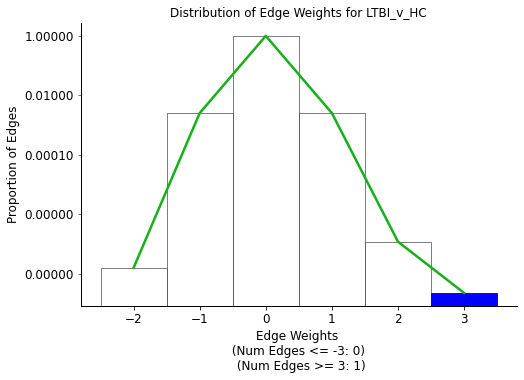

In [16]:
fig , ax = plt.subplots()

plot_distribution_of_edge_weights(ax, edge_weight_distr_counter_dict, f'Distribution of Edge Weights for {comparison_X}', 'xkcd:green')

fig = plt.gcf()
fig.set_size_inches(7.5, 5.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### minimum/maximum edge weights

In [17]:
np.min(network_edge_weight_matrix)

-2

In [18]:
np.max(network_edge_weight_matrix)

3

## Construct NetworkX graph from edge weight matrix

#### Retrieve the indices for the upper-triangular part of the matrix, normalize edge weights & construct list of edges

Have to (1) retrieve the edges from the upper-triangle of the matrix, (2) convert all to positive edge weights & (3) divide by the number of datasets

In [19]:
#Return the upper triangular part of the matrix with elements in lower part ZEROED out
upper_tri_network_edge_weight_matrix = np.triu(network_edge_weight_matrix, k = 0)

#Return a boolean for elements in the upper triangular part of the matrix for elments that are <= -3 OR >= 3
upper_tri_network_edge_weight_matrix_bool = abs(upper_tri_network_edge_weight_matrix) >= 3

#get the indices for the elements in the upper triangle where elements (edge weights) <= -3 OR >= 3
node_i_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[0]
node_j_indices = upper_tri_network_edge_weight_matrix_bool.nonzero()[1]

#get the normalization factor (number of datasets used to construct edge weights = maximum possible weight)
edge_weight_norm_factor = float(num_datasets_per_comparison[comparison_X])

#Create list of edges for NetworkX graph by iterating through numpy (adjancency) matrix (with edge weights) + node labels (rows/columns of matrix) & storing edges with weights <= -3 OR >= 3
G_edge_list = [ ( network_edge_weight_matrix_labels[node_i], network_edge_weight_matrix_labels[node_j], (float(abs(network_edge_weight_matrix[node_i, node_j]))/edge_weight_norm_factor) ) for node_i, node_j in zip(node_i_indices, node_j_indices)]

In [20]:
G_edge_list[0:10]

[('ATF3', 'ATF3', 0.3333333333333333)]

In [21]:
len(G_edge_list) #number of edges (gene-gene pairs with edge weights <= -3 OR >= 3)

1

#### Construct NetworkX graph from list of Edges

In [22]:
G = nx.Graph()
G.add_weighted_edges_from(G_edge_list)

In [23]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1
Number of edges: 1
Average degree:   2.0000


Pickle the network for downstream analysis

In [24]:
nx.write_gpickle(G , pickled_objects_dir + f'Network Files/networks/{comparison_X}.pkl')
# use nx.read_gpickle( pickled_objects_dir + f'Network Files/networks/{comparison_X}.pkl') to load

## Get mean $log_2$(Fold Change) for all genes in network

Create a series that stores the mean $log2(FC)$ across datasets from the $log2(FC)$ matrix (rows = genes & columns = datasets)

when averaging $log2(FC)$ across datasets, **only include the non-zero** datasets (columns)???

- datasets in which logFC for a gene = 0 are due to q-value threshold or logFC threshold???

In [27]:
genes_in_network = list(G.nodes()) #get all nodes in the network
mean_logFC_series = pd.Series(index = genes_in_network) #create series

for gene_i in mean_logFC_series.index:
    
    #use code below to calculate average logFC for gene across datasets (ignoring the entries where logFC = 0)
    #gene_i_mean_logFC = float(diff_gene_exp_df.loc[gene_i , :].sum()) / float(np.sum(diff_gene_exp_df.loc[gene_i , :] != 0.0))
    
    #use code below to calculate average logFC for gene across ALL datasets/studies
    gene_i_mean_logFC = diff_gene_exp_df.loc[gene_i , :].mean()
    
    #append to series
    mean_logFC_series[gene_i] = gene_i_mean_logFC
    
mean_logFC_series.sort_values(inplace = True, ascending = False)

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [30]:
diff_gene_exp_df.loc[gene_i , :]

GSE19439     0.000000
GSE19444     0.000000
GSE28623     0.000000
GSE41055     0.000000
GSE54992     0.000000
GSE62525    -1.879255
GSE84076     0.000000
GSE107993    0.639942
GSE107994    0.686461
Name: ATF3, dtype: float64

In [28]:
mean_logFC_series.head(n = 15)

ATF3   -0.061428
dtype: float64

In [29]:
mean_logFC_series.tail(n = 15)

ATF3   -0.061428
dtype: float64

In [32]:
np.shape(mean_logFC_series)

(1,)

Pickle **mean $log2(FC)$** series for comparison with other networks and downstream analysis

In [31]:
mean_logFC_series.to_pickle(pickled_objects_dir + f'Network Files/mean logFC network nodes series/{comparison_X}.pkl')